In [ ]:
import matplotlib.pyplot as plt
import tqdm
from time import time

# Estructura de los datos.

Tenemos 3043 observaciones de dimensión 500. Estas características provienen de un análisis de componentes principales, pues se buscó reducir la dimensión.

# Datos del ejercicio

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("OTUS_conservados.csv")
print(df.head())
from sklearn.utils import shuffle
#df = shuffle(df)###El ajuste depende de este shuffle*****

           X            New_Labels  Latitude  Longitude  X4457032  X4471583  \
0  1001.skm3  WarmT-SumDry-HotSum0    33.194   -117.241  0.003306       0.0   
1  1001.skd3  WarmT-SumDry-HotSum0    33.194   -117.241  0.002699       0.0   
2  1001.skm1  WarmT-SumDry-HotSum0    33.194   -117.241  0.001304       0.0   
3  1001.skb3  WarmT-SumDry-HotSum0    33.194   -117.241  0.009130       0.0   
4  1001.skm2  WarmT-SumDry-HotSum0    33.194   -117.241  0.001022       0.0   

   X9560  X4468101  X198079   X101868  ...  X210657  X218246    X48487  \
0    0.0       0.0      0.0  0.005785  ...      0.0  0.00000  0.004752   
1    0.0       0.0      0.0  0.001080  ...      0.0  0.00000  0.003419   
2    0.0       0.0      0.0  0.002934  ...      0.0  0.00000  0.004563   
3    0.0       0.0      0.0  0.004966  ...      0.0  0.00016  0.004645   
4    0.0       0.0      0.0  0.000341  ...      0.0  0.00000  0.005112   

     X81081  X1787355  X6159  X154268   X855996   X99400  X716037  
0  0.007231 

In [ ]:
print(df.shape)

(3043, 607)


In [ ]:
import numpy as np

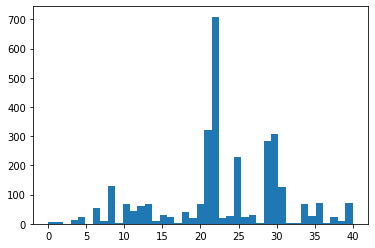

In [ ]:
ytags=df['New_Labels']

_,idx = np.unique(ytags,return_inverse=True)
plt.hist(idx,bins=len(_))
plt.show()#Mala representatividad de clases.

# Definición del modelo.

In [ ]:
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras import models

Se considera un modelo 2 dos capas ocultas de tipo densas. Una con 256 nodos y la otra con 64, cada una con función de activación de tipo "relu".

Para la clasificación, se utiliza una función de pérdida de tipo categórica-crossentropy, con una capa de salida de 41 clases, una para cada etiqueta única definida en los datos.

Se da un número fijo de epocas (20) y un batch-size fijo (10)

#k-Cross-validation. 

Consideraremos distintos datos de entrenamiento/validación a fin de promediar el desempeño obtenido.

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score,roc_auc_score

from sklearn.metrics import f1_score, cohen_kappa_score
import seaborn as sns 

In [ ]:
input_shape=603
def RN(X_train_set,Y_train_set,X_val_set,Y_val_set):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_shape,), name='Input_Layer'))#Obligatoria
    model.add(layers.Dense(512, activation='relu'))# Numero de capas ocultas: Opcional
    model.add(layers.Dense(64, activation='relu'))# Numero de neuronas en cada capa: Opcional
    model.add(layers.Dense(41, activation='Softmax', name='Output_Layer'))#Obligatoria
    #model.summary()
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.fit(x = X_train_set, 
            y = Y_train_set,##Cuando haya otra base, se modifica ese 200
            batch_size=10,
            epochs=20,
            verbose=0,shuffle=True)
    test_predicted_labels_raw = model.predict(X_val_set)
    test_true_labels      = np.argmax(Y_val_set,axis=1)
    test_predicted_labels = np.argmax(test_predicted_labels_raw,axis=1)
    accuracy = accuracy_score(test_true_labels,test_predicted_labels)
    precision = precision_score(test_true_labels,test_predicted_labels,average='weighted',zero_division=1)
    recall = recall_score(test_true_labels,test_predicted_labels,average='weighted',zero_division=1)
    f1 = f1_score(test_true_labels,test_predicted_labels,average='weighted')
    return(accuracy,precision,recall,f1)


In [ ]:
from keras.utils import to_categorical
K=5# se consideran 20 subconjuntos aleatorios de entrenamiento.
metrics=np.zeros((K,4))
for k in range(K):
    df=shuffle(df)##Este hace todo el truco
    ytags=df['New_Labels']
    X_total=df.drop(columns=['X','New_Labels','Latitude','Longitude'])
    _,idx = np.unique(ytags,return_inverse=True)
    Y_total=to_categorical(idx)
    train_perc=int(0.80*len(X_total))
    X_train=X_total[0:train_perc]
    Y_train=Y_total[0:train_perc]
    X_val=X_total[train_perc:]
    Y_val=Y_total[train_perc:]
    metrics[k]=RN(X_train_set=X_train,Y_train_set=Y_train,X_val_set=X_val,Y_val_set=Y_val)
    if(k%5==0):
        print(k)

20/20 [==============================] - 1s 12ms/step
0
20/20 [==============================] - 0s 3ms/step


#Métricas de desempeño.

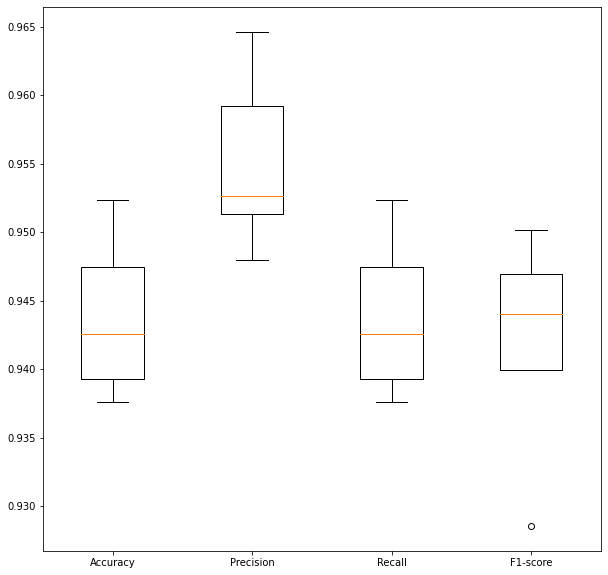

In [ ]:
plt.figure(figsize=(10,10))
plt.boxplot(metrics[:,0:],labels=['Accuracy','Precision','Recall','F1-score'])
plt.show()

## Promedios

In [ ]:
from tabulate import tabulate
print(tabulate([[str(np.round(metrics.mean(0).tolist()[i],4)) for i in range(4)]], headers=["Accuracy", "Precision","Recall", "F1-score"]))

  Accuracy    Precision    Recall    F1-score
----------  -----------  --------  ----------
    0.9529       0.9612    0.9529      0.9508


Recordemos que se trata de un problema multiclase, por lo que se puede decir que tenemos un muy buen desempeño en la clasificación.